In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import format_number, when, col, array, udf, lit
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("Predictive Crime Analysis - Indian Dataset")\
                .config("spark.some.config.option", "some-value")\
                .config("spark.driver.memory", "4g")\
                .config("spark.driver.cores", "1")\
                .getOrCreate()

21/12/11 06:23:08 WARN Utils: Your hostname, Aryans-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.10 instead (on interface en0)
21/12/11 06:23:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/11 06:23:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
crime_schema = StructType([
    StructField("Event", StringType(), True),
    StructField("Circle", StringType(), True),
    StructField("Police Station", StringType(), True),
    StructField("Caller Source", StringType(), True),
    StructField("Event Type", StringType(), True),
    StructField("Event Sub-Type", StringType(), True),        
    StructField("Date", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True)
])

In [4]:
dataset =spark.read.option("header", "True")\
        .option("inferSchema", "true").csv("originaldataset2.csv")

In [5]:
dataset.printSchema()

root
 |-- District: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Circle: string (nullable = true)
 |-- Police Station: string (nullable = true)
 |-- Caller Source: string (nullable = true)
 |-- Event Type: string (nullable = true)
 |-- Event Sub-Type: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [69]:
dataset.limit(5).toPandas().head()

,District,Event,Circle,Police Station,Caller Source,Event Type,Event Sub-Type,Date,Latitude,Longitude
0,LUCKNOW,P01042100004,C1,PS1,PHONE,Information Against Police,Misbehavior By Prv,01/04/2021 00:00:00,26.834,81.008
1,LUCKNOW,P01042104316,C1,PS1,PHONE,Threat In Person,Attack,01/04/2021 12:09:00,26.828,81.014
2,LUCKNOW,P01042104847,C1,PS1,PHONE,Dispute,Dispute In Hospital,01/04/2021 12:51:00,26.840,81.009
3,LUCKNOW,P01042105074,C1,PS1,PHONE,Gambling,Play Cards,01/04/2021 13:10:00,26.828,81.002
4,LUCKNOW,P01042105152,C1,PS1,PHONE,Threat In Person,Attack,01/04/2021 13:18:00,26.834,81.033


In [6]:
dataset = dataset.filter((dataset["Event Type"] != "Corona")&
                          (dataset["Event Type"] != "Unknown")&
                          (dataset["Event Type"] != "#N/A")&
                          (dataset["Event Type"] != "Sos")&
                          (dataset["Event Type"] != "Unclaimed Information")&
                          (dataset["Event Type"] != "Police Help Required By 108") ) 

In [7]:
dataset=dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "dd/MM/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset=dataset.withColumn("Hour", F.split(F.split(dataset.Date," ")[1], ":")[0].cast("int"))
dataset=dataset.na.drop()
dataset.limit(5).toPandas().head()

,District,Event,Circle,Police Station,Caller Source,Event Type,Event Sub-Type,Date,Latitude,Longitude,Day,Month,WeekDay,Hour
0,LUCKNOW,P01042100004,C1,PS1,PHONE,Information Against Police,Misbehavior By Prv,01/04/2021 00:00:00,26.834,81.008,2021-04-01,4,5,0
1,LUCKNOW,P01042104316,C1,PS1,PHONE,Threat In Person,Attack,01/04/2021 12:09:00,26.828,81.014,2021-04-01,4,5,12
2,LUCKNOW,P01042104847,C1,PS1,PHONE,Dispute,Dispute In Hospital,01/04/2021 12:51:00,26.840,81.009,2021-04-01,4,5,12
3,LUCKNOW,P01042105074,C1,PS1,PHONE,Gambling,Play Cards,01/04/2021 13:10:00,26.828,81.002,2021-04-01,4,5,13
4,LUCKNOW,P01042105152,C1,PS1,PHONE,Threat In Person,Attack,01/04/2021 13:18:00,26.834,81.033,2021-04-01,4,5,13


In [8]:
dataset.groupby('Event Type').count().orderBy('count', ascending=False).show()


+--------------------+-----+
|          Event Type|count|
+--------------------+-----+
|             Dispute| 1549|
|   Domestic Violence|  596|
|    Threat In Person|  578|
|               Theft|  339|
|Information Again...|  167|
|Crime On Phone Mo...|  130|
|   Property Disputes|  128|
|             Missing|  101|
|Female Sexual Har...|   76|
|             Robbery|   71|
|     Animals Related|   62|
|            Gambling|   54|
|        Cyber Crimes|   53|
|         Medium Fire|   53|
|           Pollution|   44|
|  Female Harrassment|   43|
|        Encroachment|   34|
|      Found Deadbody|   32|
|Suspicious Person...|   29|
|Information Again...|   27|
+--------------------+-----+
only showing top 20 rows



In [9]:
dataset = dataset.na.drop()

Text(0, 0.5, 'Crime Type')

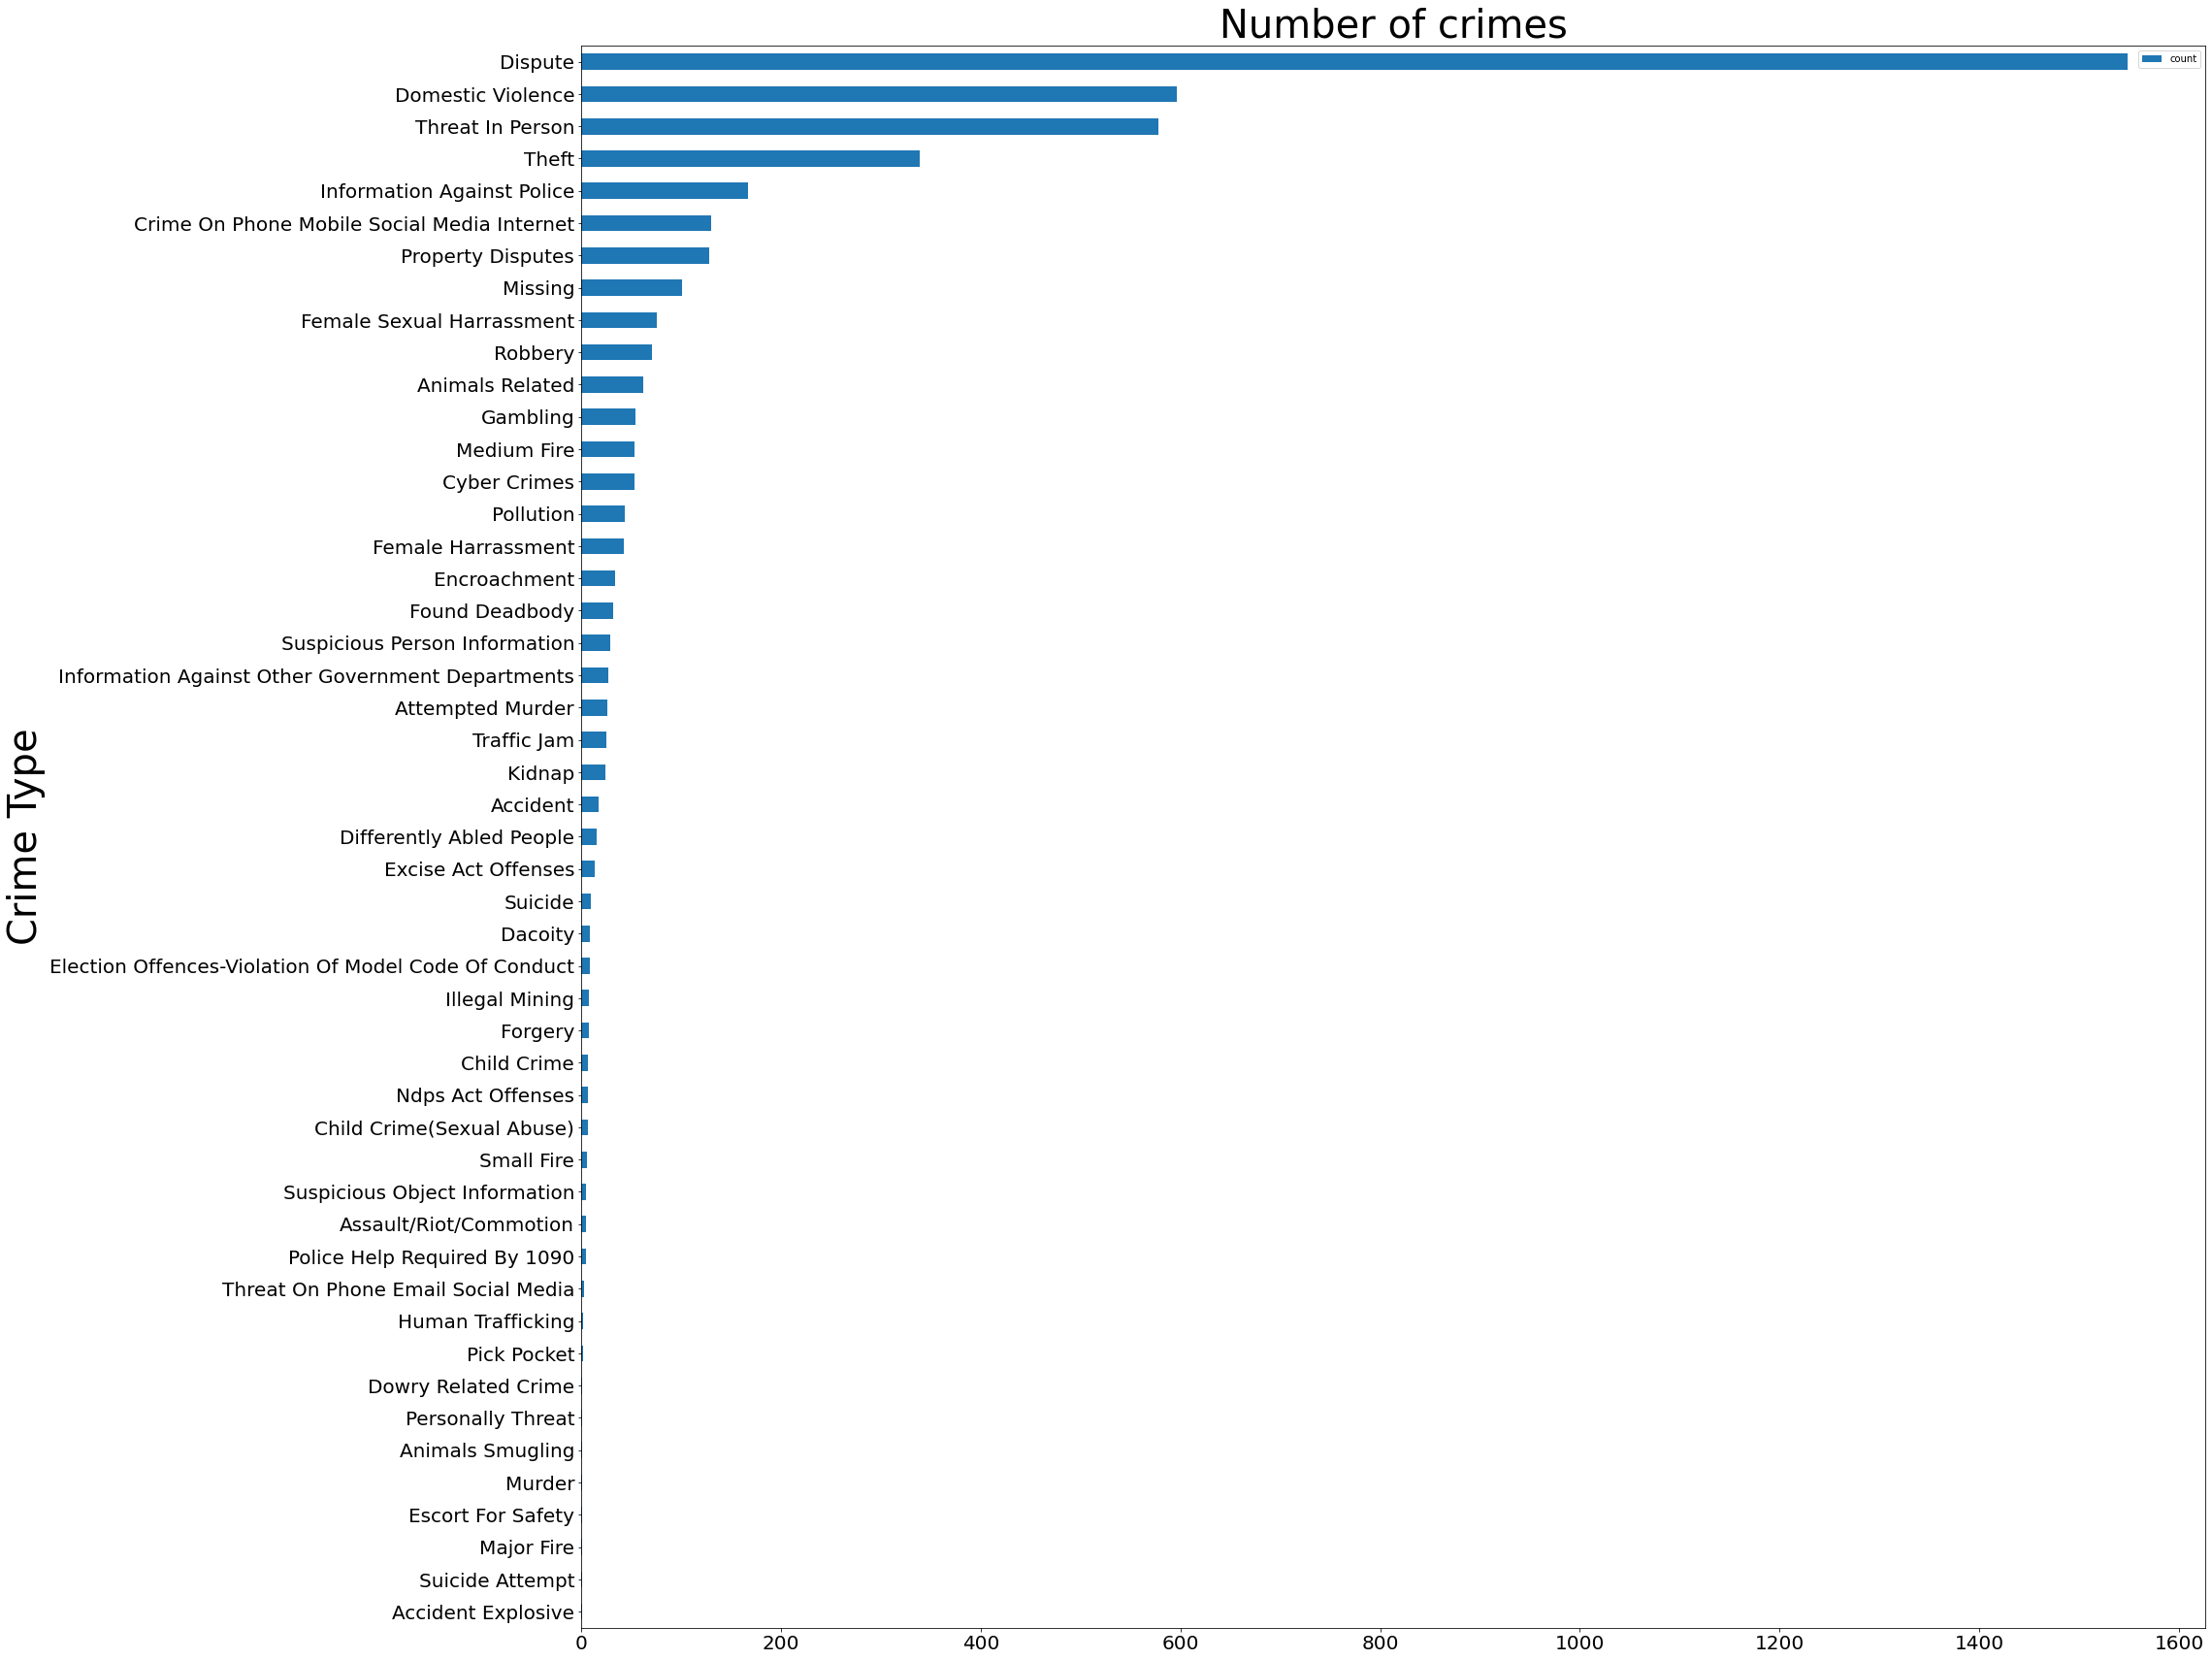

In [10]:
dataset.groupBy("Event Type")\
        .count().toPandas().sort_values(by='count')\
        .plot(x='Event Type',y='count',\
                      sort_columns=True,kind='barh', \
                      figsize=(30, 30),fontsize=20)
plt.title("Number of crimes", fontsize=40)
plt.ylabel('Crime Type', fontsize=40)

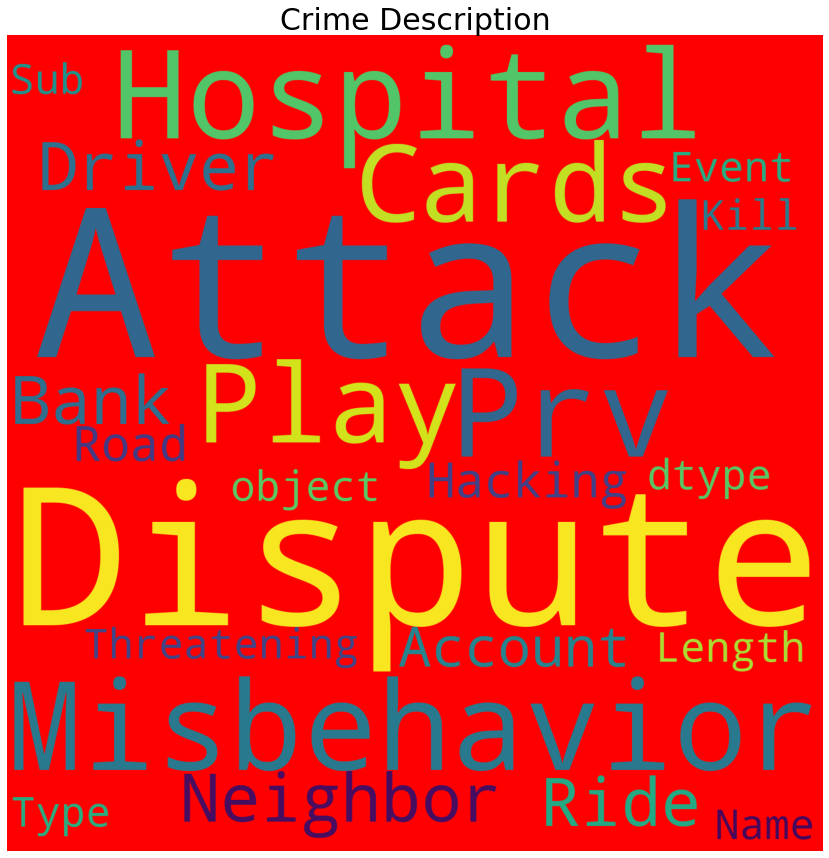

In [13]:
## Extras
!pip install wordcloud
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')
wc = WordCloud(background_color = 'red', \
               width = 1500, height = 1500)\
               .generate(str(dataset.toPandas()['Event Sub-Type']))
plt.title('Crime Description', fontsize = 30)
plt.imshow(wc)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Police Station')

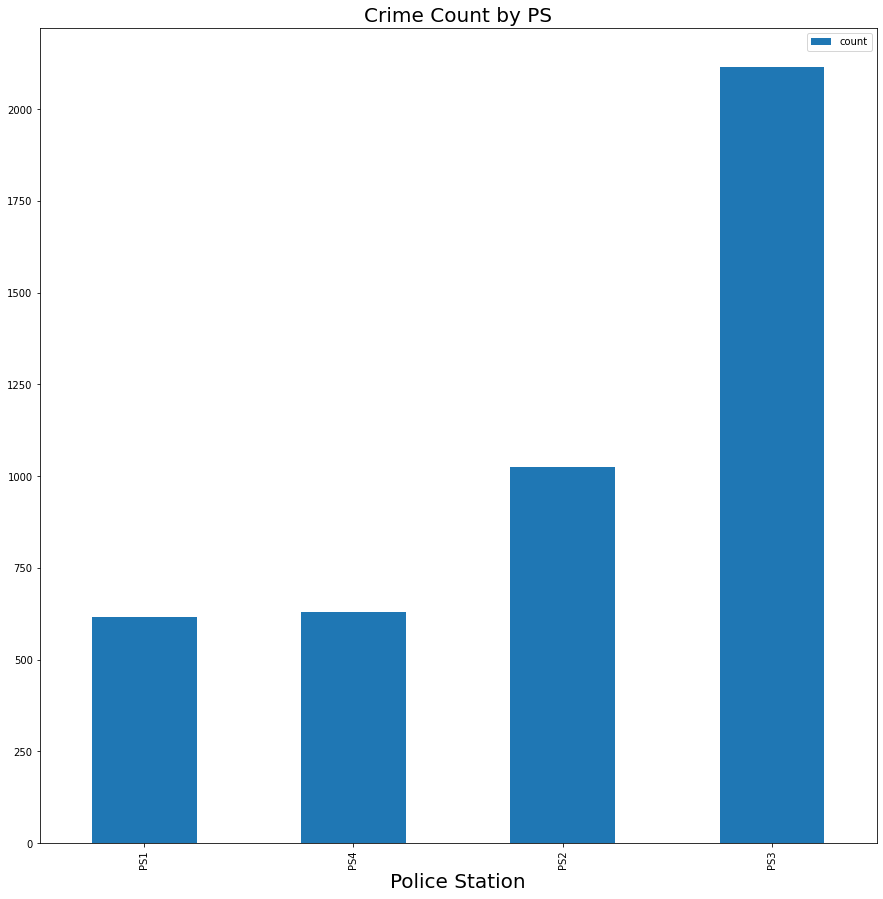

In [14]:
dataset.groupBy("Police Station")\
        .count().sort("count", ascending=False).limit(10)\
        .toPandas().sort_values(by="count")\
        .plot(x='Police Station', y="count", sort_columns = True, kind = 'bar',\
             figsize = (15, 15), fontsize = 10)
plt.title("Crime Count by PS", fontsize=20)
plt.xlabel("Police Station", fontsize=20)

In [16]:
# !pip install folium
!pip install branca==0.3.1
import folium
from folium import plugins
from folium.plugins import HeatMap

latitude = 26.864
longitude = 81.036


heatMap = folium.Map(location=[latitude, longitude], 
                 tiles = "OpenStreetMap",
                zoom_start=12)
hotspot = dataset.toPandas().head(20000)
heat_data = [[row['Latitude'],row['Longitude']] for index, row in hotspot.iterrows()]
HeatMap(heat_data, radius=10).add_to(heatMap)

heatMap

  Attempting uninstall: branca
    Found existing installation: branca 0.4.2
    Uninstalling branca-0.4.2:
      Successfully uninstalled branca-0.4.2
